# Learning a multimodal distribution

Affine Autoregressive Transforms to learn the transform from a standard normal into a two-moon distribution. The code is light and can be run on a local laptop; no GPUs needed.

- Transforms are based on `pyro`, which closely embraces the `torch.distributions` library.
- `sklearn` two-moon dataset is used.
- `matplotlib` for plotting

In [1]:
# !pip install pyro sklearn matplotlib

In [2]:
import matplotlib.pyplot as plt

import numpy as np
from sklearn import datasets

import torch
from torch import distributions as dist
from torch import optim

from pyro.nn import AutoRegressiveNN
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import AffineAutoregressive

In [3]:
samples, labels = datasets.make_moons(n_samples=1000, noise=0.1)

Text(0, 0.5, '$y$')

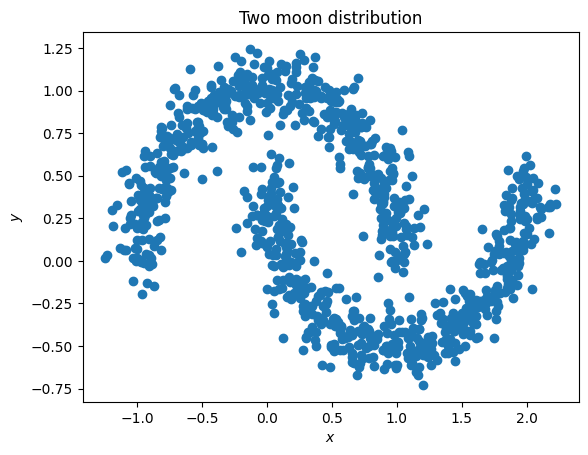

In [4]:
plt.scatter(samples.T[0], samples.T[1])
plt.title("Two moon distribution")
plt.xlabel("$x$")
plt.ylabel("$y$")

In [5]:
samples = torch.from_numpy(samples).to(dtype=torch.float32)

In [6]:
linear_transform = transforms.linear.NaiveLinear(features=10)

NameError: name 'transforms' is not defined

In [ ]:
x = torch.randn(10, 10)

In [ ]:
linear_transform(x)

## Autoregressive Net and Transform

The flow we implement below has affine autoregressive transforms. Most of the constructs are available in the `pyro` API.

In [7]:
input_dim = 2  # data dimension
hidden_dims = [100*input_dim, 100*input_dim, 100*input_dim]

base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))

arn = AutoRegressiveNN(input_dim, hidden_dims, param_dims=[1, 1])

In [8]:
arn

AutoRegressiveNN(
  (layers): ModuleList(
    (0): MaskedLinear(in_features=2, out_features=200, bias=True)
    (1): MaskedLinear(in_features=200, out_features=200, bias=True)
    (2): MaskedLinear(in_features=200, out_features=200, bias=True)
    (3): MaskedLinear(in_features=200, out_features=4, bias=True)
  )
  (f): ReLU()
)

In [9]:
transform =  AffineAutoregressive(arn)  # the "affine" part implies the linear relation between hidden dimensions

In [10]:
# the flow implementation is torch transformed distribution
flow_dist = dist.TransformedDistribution(base_dist, [transform])

In [11]:
optimizer = optim.Adam(transform.parameters(), lr=1e-4)

In [12]:
from IPython.display import clear_output
from time import sleep

def live_plot(x_vals, y_vals, iteration):
    """Auxiliary function to visualize the distribution"""
    clear_output(wait=True)
    sleep(1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(x_vals, y_vals, label='proxy')
    ax.scatter(samples.T[0], samples.T[1], alpha=0.1, label='Orig.')
    ax.legend()
    ax.set_title('iteration {}'.format(iteration))

## Learn the Transform

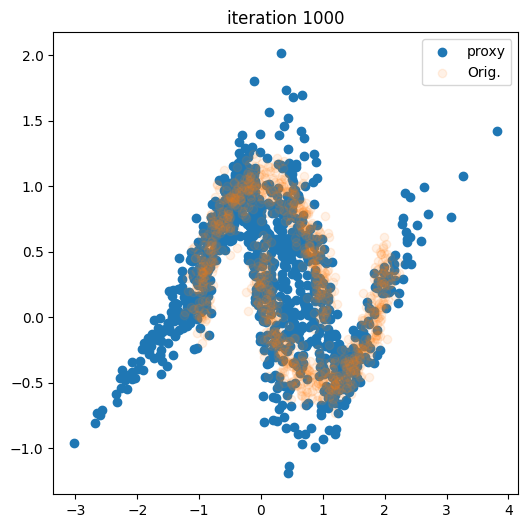

In [13]:
num_iter = 1000
for i in range(num_iter):

    optimizer.zero_grad()
    # take the original samples, and evaluate the likelihood.
    loss = -flow_dist.log_prob(samples).mean()
    loss.backward()
    optimizer.step()

    flow_dist.clear_cache()  # pyro modules cache values and derivatives for performance

    if (i + 1) % 100 == 0:
        with torch.no_grad():
            samples_flow = flow_dist.sample(torch.Size([1000,])).numpy()
        live_plot(samples_flow[:,0], samples_flow[:,1], i + 1)
        plt.show()

## Compose several transforms

In the previous case we just had a single transform

In [14]:
hidden_dims = [50*input_dim, 50*input_dim, 50*input_dim]

transforms = [
    AffineAutoregressive(
        AutoRegressiveNN(input_dim, hidden_dims,
                         param_dims=[1, 1])
    ) for _ in range(5)
]

In [15]:
flow_dist = dist.TransformedDistribution(base_dist, transforms)

In [16]:
trainable_parameters = []

for t in transforms:
    trainable_parameters.extend(list(t.parameters()))

In [17]:
optimizer = optim.Adam(trainable_parameters, lr=1e-4)

### Learn the transform

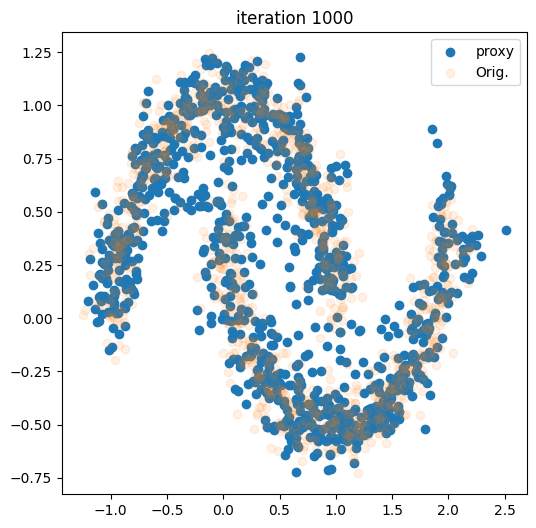

In [18]:
num_iter = 1000
for i in range(num_iter):

    optimizer.zero_grad()
    loss = -flow_dist.log_prob(samples).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if (i + 1) % 100 == 0:
        with torch.no_grad():
            samples_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()

        live_plot(samples_flow[:,0], samples_flow[:,1], i + 1)
        plt.show()

In [19]:
num_parameters = lambda parameters: sum(p.numel() for p in parameters if p.requires_grad)

In [20]:
print("Trainable parameters of single transform =", num_parameters(transform.parameters()))

Trainable parameters of single transform = 81804


In [21]:
print("Trainable parameters of after composing transforms =", num_parameters(trainable_parameters))

Trainable parameters of after composing transforms = 104520


# Things to try

- Compare results/number of trainable parameters from other flavors of autoregressive nets: splines, neural autoregressive etc.
- Compare results/number of parameters with coupling layers instead. Note that like affine/spline autoregressive, there is the corresponding affine/spline coupling transforms.

# Other exercises

Depending on whether the masked feed-forward layers are implemented from "data" to "normal" direction or opposite, the flow is called masked-autoregressive or inverse-autoregressive. Look at the `pyro` source code on github and infer which one is the above implementation.

## When the distribution is easy to evaluate

In the exercise above we had "samples" from the the two-moon distribution, but did not have access to the true distribution. Consider the other regime, where we can evaluate the true distribution i.e. don't have samples. Train a flow to learn the following distribution.

In [22]:
def multimodal_pdf(x, y):
    res = np.exp(
        - x**2 - (8 + 4*x**2 + 8*y)**2
    )
    res += 0.5*np.exp(
        - 8*x**2 - 8*(y - 2)**2
    )
    res *= 16./3./np.pi
    return np.log(res)

Text(0, 0.5, '$y$')

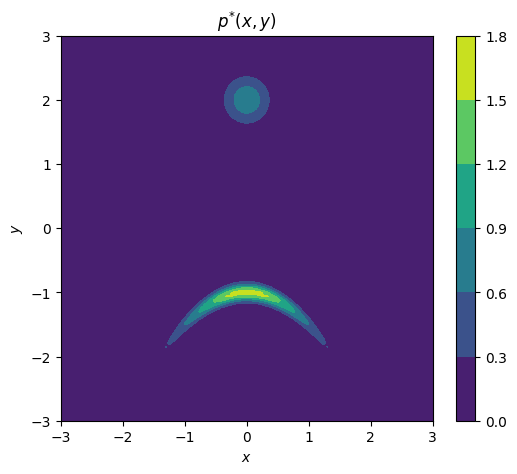

In [23]:
x_vals = np.linspace(-3, 3, 100)
y_vals = np.linspace(-3, 3, 100)

X, Y = np.meshgrid(x_vals, y_vals)

Z = multimodal_pdf(X, Y)

fig, ax = plt.subplots(figsize=(6, 5))
cs = ax.contourf(X, Y, np.exp(Z), levels=5)
cbar = fig.colorbar(cs)

ax.set_title("$p^{*}(x, y)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")